I was sceptical as to whether the neural network was really working how we thought it was. I was suspicious that it was ignoring the first 3 features, and was merely recovering the linear relationship between Q400 and muon charge that we had discovered earlier (see for example muon_charge_E_binned_past_400m_Proton.png in the figures folder). 

To investigate this, I set the first 3 features equal to zero for every shower in the test set. I discovered that the neural network's predicitons were unchanged (i.e. the network only relies on Q400).

To further test the hypothesis, I made a linear fit for muon charge vs Q400, and got nearly identical results to the neural network.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

C:\Users\jfcre\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### First I am going to make and plot the best model from the manual tuning notebook. Then I will test this model while setting test set features equal to zero. Finally, I will make the linear fit and print the results

A note about the data:

The data is generated by a python 2 script, that saves the data as an array of arrays.

Each row is a different shower. 

The columns are:
1. run #
2. reconstructed energy (using mixed composition assumption)
3. reconstructed zenith angle
4. the sum of the absolute signal time delays past the cut-off distance
5. the total charge >0.6 VEM & <2.0 VEM, past the cut-off distance
6. the number of muon VEMs
7. the number of muons to intersect IceTop tanks
8. the primary type

Run number, and primary type aren't used for the neural networks (actually the run number IS used for the averaged neural network, but that's in it's own notebook). Currently the number of intersecting muons is useless. Most of the showers don't yet contain this information. Until they do, use the number of muon VEMs instead 

Load and convert the data to python3 type

In [2]:
# Columns: Run, Energy, Zen, Time delay, Q400, MuonVEM, nMuon, Type
# Note that right now, nMuon is useless
data = np.load('./data/NN_data.npy')

# convert the python 2 bytes into python 3 format
data_ = []
for i in range(len(data)):
    data_.append([])
    for j in range(0,7):
        data_[i].append(float(data[i,j]))
    # convert types to numbers. proton = 1, iron = 2
    if data[i,7] == b'PPlus':
        data_[i].append(1)
    else:
        data_[i].append(2)
data = np.array(data_)

Select data with $\ log(E) \in (16.0,16.5)\ $  and  $\ cos(zenith) > 0.9$

In [3]:
data_ = []
for shower in data:
    E    = shower[1]
    logE = np.log10(E)
    zen  = shower[2]
    if logE >= 16 and logE <= 16.5 and np.cos(zen) > 0.9:
        data_.append(shower)
data_trimmed = np.array(data_)

Split data into input (X) and output (Y)

In [4]:
X = data_trimmed[:,1:-3]
Y = data_trimmed[:,-3]

split the data into test and training set

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X,Y)

normalize the data sets

In [6]:
# normalize the data because the network will be sensitive
# to relative magnitudes
scaler = StandardScaler()
scaler.fit(x_train)

# apply the scaler to the sets
x_train = scaler.transform(x_train)
x_test  = scaler.transform(x_test)

#### Create the neural network and fit it to the training data

In [7]:
seed = 11
np.random.seed(seed)

# parameters
epochs     = 40
batch_size = 10

# create model
model = Sequential()
model.add(Dense(20,input_dim=4,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)


Plot the results of the neural network on the test set

 MSE: 11.954 (0.000)
MAPE: 25.994 (0.000)


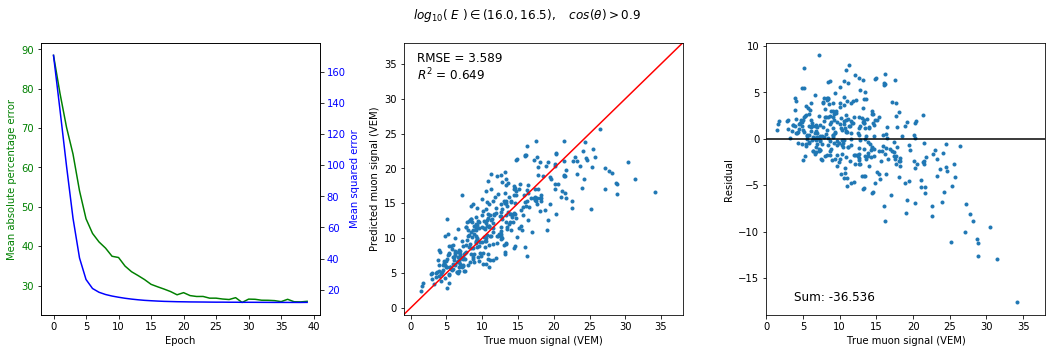

In [8]:
# print out the mean squared error and mean absolute percentage error of the last 10% of epochs
look_back = -int(batch_size*0.1)
look_back_mse  = history.history['mean_squared_error'][look_back:]
look_back_mape = history.history['mean_absolute_percentage_error'][look_back:]
print(r' MSE: {0:.3f} ({1:.3f})'.format(np.mean(look_back_mse),np.std(look_back_mse)))
print(r'MAPE: {0:.3f} ({1:.3f})'.format(np.mean(look_back_mape),np.std(look_back_mape)))

# plot the metrics vs epoch number

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
ax1.plot(history.history['mean_absolute_percentage_error'],color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean absolute percentage error',color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax1_ = ax1.twinx()
ax1_.plot(history.history['mean_squared_error'],color='blue')
ax1_.set_ylabel('Mean squared error',color='blue')
ax1_.tick_params(axis='y', labelcolor='blue')

# plot predictions vs true values

PREDICTION = model.predict(x_test)
TRUTH      = y_test

# prediction vs truth
ax2.scatter(TRUTH,PREDICTION,marker='.')
# line y=x
xmax = int(1.1*max(TRUTH)+0.5)
x = np.linspace(-1,xmax)
ax2.plot(x,x,color='r')
# stats
rmse = np.sqrt(mean_squared_error(TRUTH,PREDICTION))
R2 = r2_score(TRUTH,PREDICTION)
ax2.text(0.05,0.93,'RMSE = {0:.3f}'.format(rmse),transform=ax2.transAxes,fontsize=12)
ax2.text(0.05,0.865,'$R^2$ = {0:.3f}'.format(R2),transform=ax2.transAxes,fontsize=12)
# axes
ax2.set_xlabel('True muon signal (VEM)')
ax2.set_ylabel('Predicted muon signal (VEM)')
ax2.set_xlim(-1,xmax)
ax2.set_ylim(-1,xmax)
# title
fig.suptitle(r'$log_{10}(\ E\ ) \in (16.0,16.5),\quad cos(\theta) > 0.9$')

# Plot residuals
residuals = [PREDICTION[i]-TRUTH[i] for i in range(len(TRUTH))]
ax3.scatter(TRUTH,residuals,marker='.')
x = np.linspace(0,xmax)
ax3.plot(x,0*x,color='black')
ax3.set_xlim(0,xmax)
ax3.set_ylabel('Residual')
ax3.set_xlabel('True muon signal (VEM)')
ax3.text(0.1,0.05,"Sum: {0:.3f}".format(sum(residuals)[0]),transform=ax3.transAxes,fontsize=12)

plt.subplots_adjust(wspace=0.3)
plt.show()

# Test which inputs are important

I will set the energy and time delay equal to zero, and the zenith angle ~ 45 degrees, for every shower in the test set. I will then use the neural network and see if the results are changed.

Result: This had no visible effect on the neural network. However, setting Q400 = 0 totally destroys the result. Thus I conclude that the neural network only cares about Q400. I think the network is just finding a linear correlation between Q400 and the muon charge. This hypothesis is test below.

##### Set  Energy, Zen, Time delay = 0

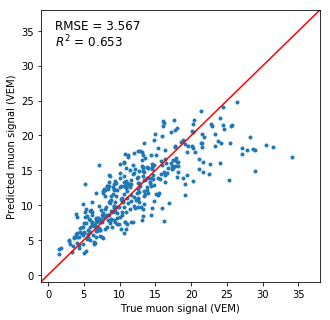

In [9]:
test_ = np.array([i for i in x_test])
test_[:,:3] = 0
test_[:,1] = 0.8 # approx 45 deg.

PREDICTION = model.predict(test_)
TRUTH      = y_test

fig_,ax_ = plt.subplots(1,1,figsize=(5,5))

# prediction vs truth
ax_.scatter(TRUTH,PREDICTION,marker='.')
# line y=x
xmax = int(1.1*max(TRUTH)+0.5)
x = np.linspace(-1,xmax)
ax_.plot(x,x,color='r')
# stats
rmse = np.sqrt(mean_squared_error(TRUTH,PREDICTION))
R2 = r2_score(TRUTH,PREDICTION)
ax_.text(0.05,0.93,'RMSE = {0:.3f}'.format(rmse),transform=ax_.transAxes,fontsize=12)
ax_.text(0.05,0.865,'$R^2$ = {0:.3f}'.format(R2),transform=ax_.transAxes,fontsize=12)
# axes
ax_.set_xlabel('True muon signal (VEM)')
ax_.set_ylabel('Predicted muon signal (VEM)')
ax_.set_xlim(-1,xmax)
ax_.set_ylim(-1,xmax)
# title
fig.suptitle(r'$log_{10}(\ E\ ) \in (16.0,16.5),\quad cos(\theta) > 0.9$')

plt.show()

##### Set  Q400 = 0

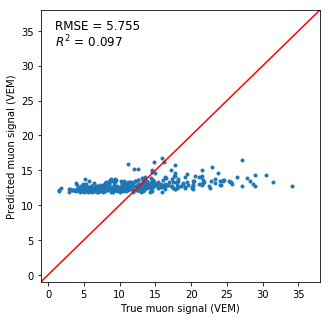

In [10]:
test_ = np.array([i for i in x_test])
test_[:,3] = 0

PREDICTION = model.predict(test_)
TRUTH      = y_test

fig_,ax_ = plt.subplots(1,1,figsize=(5,5))

# prediction vs truth
ax_.scatter(TRUTH,PREDICTION,marker='.')
# line y=x
xmax = int(1.1*max(TRUTH)+0.5)
x = np.linspace(-1,xmax)
ax_.plot(x,x,color='r')
# stats
rmse = np.sqrt(mean_squared_error(TRUTH,PREDICTION))
R2 = r2_score(TRUTH,PREDICTION)
ax_.text(0.05,0.93,'RMSE = {0:.3f}'.format(rmse),transform=ax_.transAxes,fontsize=12)
ax_.text(0.05,0.865,'$R^2$ = {0:.3f}'.format(R2),transform=ax_.transAxes,fontsize=12)
# axes
ax_.set_xlabel('True muon signal (VEM)')
ax_.set_ylabel('Predicted muon signal (VEM)')
ax_.set_xlim(-1,xmax)
ax_.set_ylim(-1,xmax)
# title
fig.suptitle(r'$log_{10}(\ E\ ) \in (16.0,16.5),\quad cos(\theta) > 0.9$')

plt.show()

## Compare neural network with linear fit

Since it looks like the neural network only cares about Q400, I think it may just be finding the linear correlation between total charge > 400m and the muon charge that we had already discovered. To test this hypothesis, I do I linear fit between these two variables, and compare the results to the neural network.

You can see that the results are almost identical. They produce the same mean squared error and $R^2$ value. Thus I conclude that the neural network is unneeded, as a simply linear fit achieves the same results.

In [11]:
from sklearn import linear_model

Mean squared error: 11.79
R2: 0.67


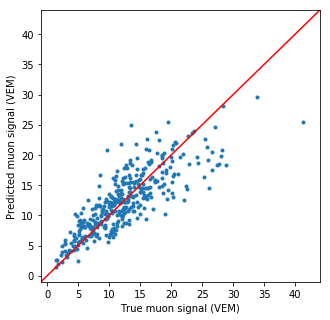

In [22]:
seed = 11
np.random.seed(seed)

x_train, x_test, y_train, y_test = train_test_split(X,Y)

TotQ_train  = x_train[:,3].reshape(-1, 1)
MuonQ_train = y_train.reshape(-1, 1)

TotQ_test  = x_test[:,3].reshape(-1, 1)
MuonQ_test = y_test.reshape(-1, 1)


# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(TotQ_train, MuonQ_train)

# Make predictions using the testing set
MuonQ_pred = regr.predict(TotQ_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(MuonQ_test, MuonQ_pred))
# R squared
print('R2: %.2f' % r2_score(MuonQ_test, MuonQ_pred))

# Plot outputs
fig_,ax_ = plt.subplots(1,1,figsize=(5,5))

# prediction vs truth
plt.scatter(MuonQ_test, MuonQ_pred,marker='.')
# line y=x
xmax = int(1.1*max(TotQ_test)+0.5)
x = np.linspace(-1,xmax)
ax_.plot(x,x,color='r')

#plt.plot(TotQ_test, MuonQ_pred,color='r')

#xmax = int(1.1*max(TotQ_test)+0.5)
ax_.set_xlabel('True muon signal (VEM)')
ax_.set_ylabel('Predicted muon signal (VEM)')
ax_.set_xlim(-1,xmax)
ax_.set_ylim(-1,xmax)

plt.show()

#### You can see that these results are nearly identical to the neural network results.